<a href="https://colab.research.google.com/github/DrPaulaEkene/Uterine-Myoma-Uterine-fibroids-Ultrasound_image-classification/blob/main/Uterine_Myoma_(Uterine_fibroids)_Ultrasound_image_classification_with_ResNet50_and_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook focuses on the Comparative Analysis of Deep Learning Architectures for Uterine Myoma Classification: Custom ResNet50 vs. Mobile Net**

*Import all needed libraries*

In [ ]:
# Make all necessary imports
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
# Import the drive module
from google.colab import drive

# Mount the Google Drive to the Colab environment.
drive.mount('/content/drive')

Mounted at /content/drive


Exploratory data analysis

In [ ]:
# Create the data file paths/directories
# Define the base directory
data_directory = "/content/drive/MyDrive/UF_dataset"

# Define directories for training and testing data
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

In [ ]:
# Print the contents of the base directory

# Function to print contents of a directory
def print_directory_contents(directory, subdirs):
    for subdir in subdirs:
        subdir_path = os.path.join(directory, subdir)
        if os.path.exists(subdir_path):
            print(f"\nContents of {subdir_path}:")
            for item in os.listdir(subdir_path):
                print(item)
        else:
            print(f"\n{subdir_path} does not exist.")

print("Contents of the base directory:")
print(os.listdir(data_directory))

# Print the contents of the training directory
print("\nContents of the training directory:")
print(os.listdir(train_directory))
print_directory_contents(train_directory, ['NUF', 'UF'])

# Print the contents of the testing directory
print("\nContents of the testing directory:")
print(os.listdir(test_directory))
print_directory_contents(test_directory, ['NUF', 'UF'])


Contents of the base directory:
['1.2.826.0.1.3680043.2.461.11301518.1849713856.jpg', '1.2.826.0.1.3680043.2.461.11301519.531737451.jpg', '1.2.826.0.1.3680043.2.461.11301521.1331253811.jpg', '1.2.826.0.1.3680043.2.461.11301521.250905338.jpg', '1.2.826.0.1.3680043.2.461.11301521.704960520.jpg', '1.2.826.0.1.3680043.2.461.11301521.1865503937.jpg', '1.2.826.0.1.3680043.2.461.11301521.4216844312.jpg', '1.2.826.0.1.3680043.2.461.11301522.742552078.jpg', '1.2.826.0.1.3680043.2.461.11301522.2857734559.jpg', '1.2.826.0.1.3680043.2.461.11301522.1372347287.jpg', '1.2.826.0.1.3680043.2.461.11301521.2436177613.jpg', '1.2.826.0.1.3680043.2.461.11301520.2658168329.jpg', '1.2.826.0.1.3680043.2.461.11301522.913479745.jpg', '1.2.826.0.1.3680043.2.461.11301525.2220413095.jpg', '1.2.826.0.1.3680043.2.461.11301523.1653786924.jpg', '1.2.826.0.1.3680043.2.461.11301523.2948715458.jpg', '1.2.826.0.1.3680043.2.461.11301524.2960341954.jpg', '1.2.826.0.1.3680043.2.461.11301525.2072747749.jpg', '1.2.826.0.1.36800

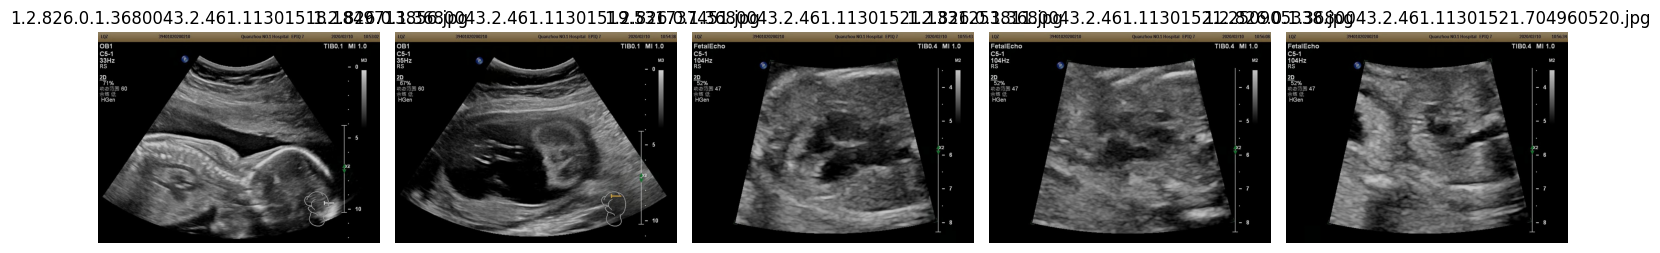

In [ ]:
# Plot 5 images from each directory
import os
import matplotlib.pyplot as plt
from PIL import Image


def plot_images(directory):
    # Get the list of files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))] # Filter out directories

    # Plot up to 5 images from the directory
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    axes = axes.flatten()

    for i, file in enumerate(files[:5]):
        # Load the image
        img_path = os.path.join(directory, file)
        img = Image.open(img_path)

        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(file)

    plt.tight_layout()
    plt.show()

# Plot 5 images from the data directory
plot_images(data_directory)

In [ ]:
from collections import defaultdict
import numpy as np

def get_image_shapes(directory):
    shapes = defaultdict(int)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                with Image.open(img_path) as img:
                    shapes[img.size] += 1
    return shapes

train_shapes = get_image_shapes(train_directory)
test_shapes = get_image_shapes(test_directory)

print("Training set image shapes:", dict(train_shapes))
print("Testing set image shapes:", dict(test_shapes))


Training set image shapes: {(1024, 768): 1576, (1138, 846): 61, (1028, 796): 105, (1026, 766): 2, (1020, 772): 19, (768, 576): 15, (1022, 786): 1, (994, 766): 1, (720, 576): 6, (1920, 1080): 2, (1136, 852): 3, (704, 666): 2, (730, 666): 1, (1160, 844): 1, (1280, 872): 4, (1034, 794): 5}
Testing set image shapes: {(1024, 768): 370, (720, 576): 2, (768, 552): 1, (1020, 772): 1, (804, 632): 1, (1028, 796): 6, (1138, 846): 15}


Feature Visualization

Training Set t-SNE Feature Visualization:


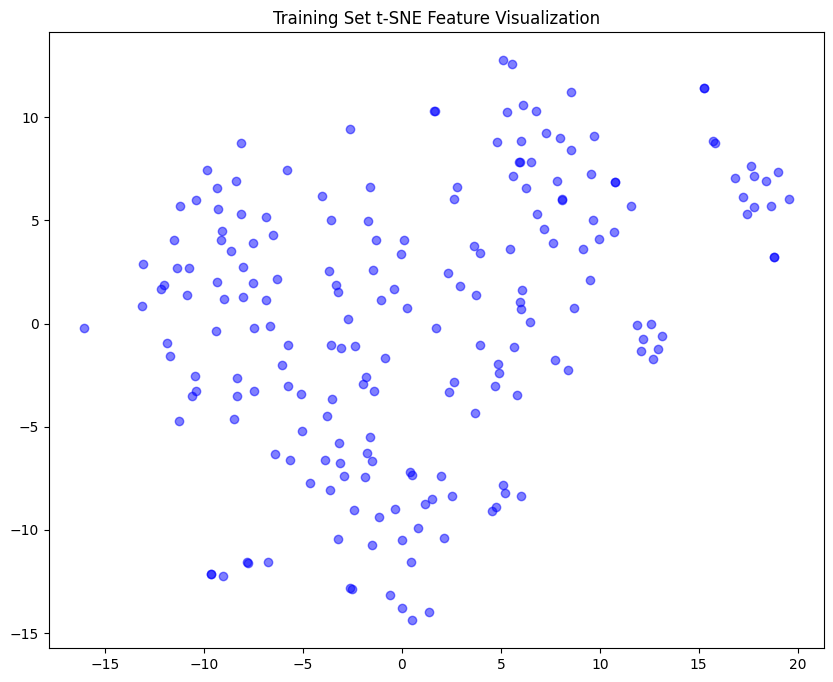

Testing Set t-SNE Feature Visualization:


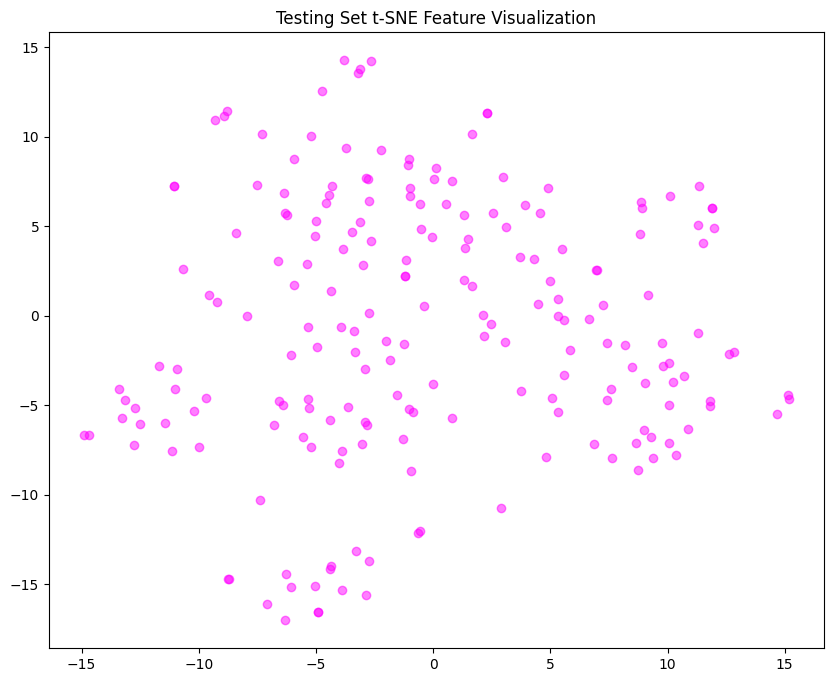

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def extract_features(directory, num_images=100):
    features = []
    for subdir, _, files in os.walk(directory):
        for file in files[:num_images]:
            if file.endswith(('jpg', 'png', 'jpeg')):
                image_path = os.path.join(subdir, file)
                with Image.open(image_path) as img:
                    img_resized = img.resize((128, 128))
                    features.append(np.array(img_resized).flatten())
    return np.array(features)

def plot_tsne_features(features, title, color='blue'):
    plt.figure(figsize=(10, 8))
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)
    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], alpha=0.5, c=color)
    plt.title(title)
    plt.show()

print("Training Set t-SNE Feature Visualization:")
train_features = extract_features(train_directory)
plot_tsne_features(train_features, 'Training Set t-SNE Feature Visualization')

print("Testing Set t-SNE Feature Visualization:")
test_features = extract_features(test_directory)
plot_tsne_features(test_features, 'Testing Set t-SNE Feature Visualization', color='magenta')

Preprocessing with imageDataGenerator

Image classification with ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
data_directory = "/content/drive/MyDrive/UF_dataset"
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
historyRes = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')


Found 1804 images belonging to 2 classes.
Found 396 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 608ms/step - accuracy: 0.5839 - loss: 0.6754 - val_accuracy: 0.4520 - val_loss: 0.6582
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 484ms/step - accuracy: 0.5573 - loss: 0.6653 - val_accuracy: 0.8131 - val_loss: 0.5902
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 476ms/step - accuracy: 0.6976 - loss: 0.6278 - val_accuracy: 0.8157 - val_loss: 0.5625
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.7212 - loss: 0.6166 - val_accuracy: 0.8333 - val_loss: 0.5306
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 474ms/step - accuracy: 0.6956 - loss: 0.6088 - val_accuracy: 0.7980 - val_loss: 0.5407
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 481ms/step - accuracy: 0.7317 - loss: 0.5766 - val_accuracy: 0.8232 - val_loss: 0.5041
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 480ms/step - accuracy: 0.7431 - loss: 0.5782 - val_accuracy: 0.7753 - val_loss: 0.5311
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 474ms/step - accuracy: 0.7485 - loss: 0.5715 - val_accuracy: 0.813

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step
Sensitivity (Recall): 0.57
Specificity: 0.52
Precision: 0.48
F1 Score: 0.52
Harmonic Mean of Precision and Recall: 0.52


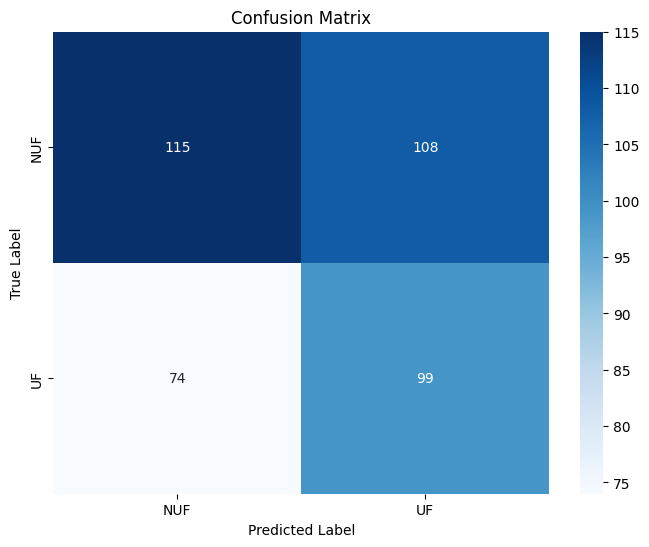

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import tensorflow as tf

def evaluate_model(model, test_generator, class_labels):
    """
    Evaluate the model on test data and print various metrics.

    Parameters:
    - model: The trained Keras model.
    - test_generator: Keras ImageDataGenerator for test data.
    - class_labels: List of class labels.
    """
    # Get true labels and predictions
    y_true = test_generator.classes
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Compute metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = recall_score(y_true, y_pred)  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    harmonic_mean = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    # Print metrics
    print(f'Sensitivity (Recall): {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Harmonic Mean of Precision and Recall: {harmonic_mean:.2f}')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model, test_generator, ['NUF', 'UF'])

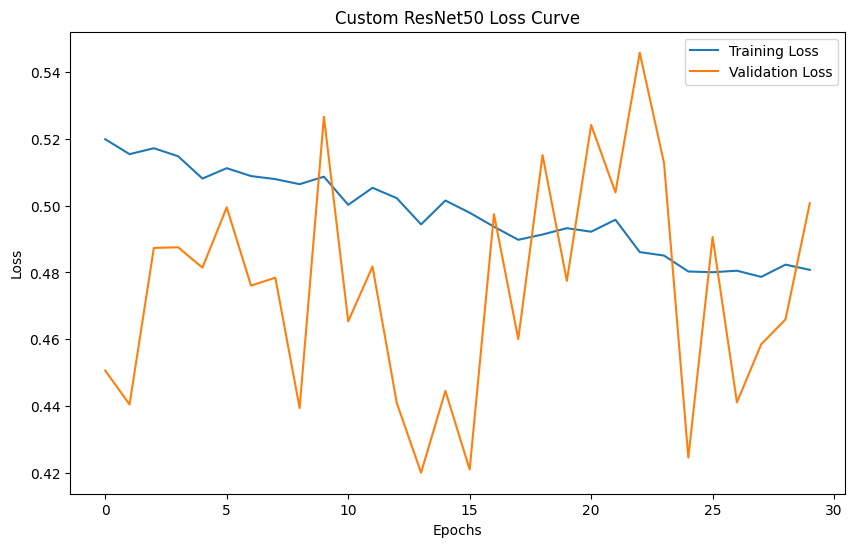

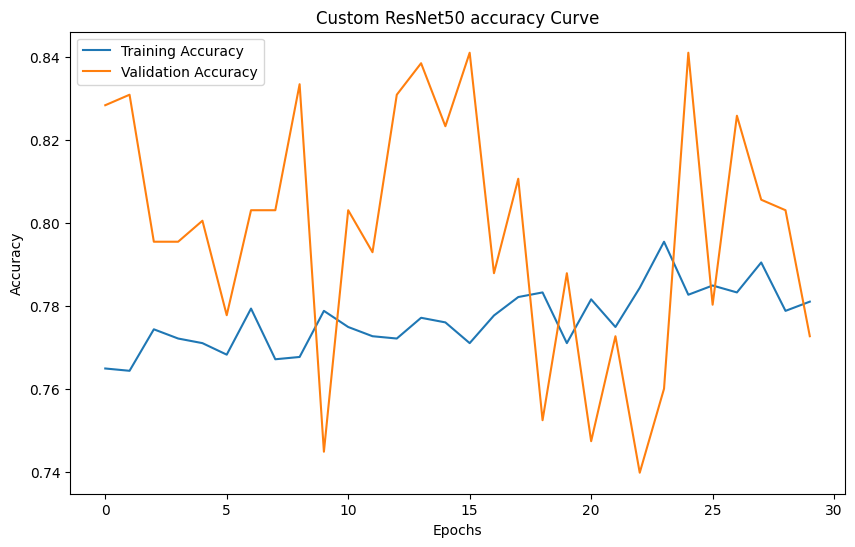

In [ ]:
# Function to plot loss curve
def plot_loss_curve(history, title='Training and Validation Loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot accuracy curve with a customizable title
def plot_accuracy_curve(history, title='Training and Validation Accuracy'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot loss and accuracy curves
plot_loss_curve(historyRes, title='Custom ResNet50 Loss Curve')
plot_accuracy_curve(historyRes,title='Custom ResNet50 accuracy Curve' )

**Modify the model for better results**

In [ ]:
# Add 10 more epochs

# Train the model
historyRes = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 564ms/step - accuracy: 0.7794 - loss: 0.5153 - val_accuracy: 0.8283 - val_loss: 0.4506
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 522ms/step - accuracy: 0.7722 - loss: 0.5105 - val_accuracy: 0.8308 - val_loss: 0.4405
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 522ms/step - accuracy: 0.7725 - loss: 0.5217 - val_accuracy: 0.7955 - val_loss: 0.4873
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 475ms/step - accuracy: 0.7794 - loss: 0.5174 - val_accuracy: 0.7955 - val_loss: 0.4875
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - accuracy: 0.7674 - loss: 0.5101 - val_accuracy: 0.8005 - val_loss: 0.4814
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 510ms/step - accuracy: 0.7676 - loss: 0.5101 - val_accuracy: 0.7778 - val_loss: 0.4995
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 533ms/step - accuracy: 0.7627 - loss: 0.5231 - val_accuracy: 0.8030 - val_loss: 0.4760
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.7653 - loss: 0.5122 - val_accu

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step
Sensitivity (Recall): 0.57
Specificity: 0.52
Precision: 0.48
F1 Score: 0.52
Harmonic Mean of Precision and Recall: 0.52


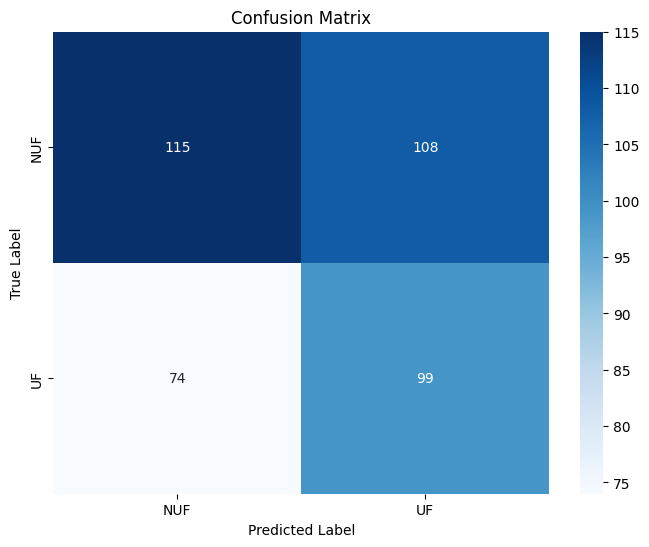

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import tensorflow as tf

def evaluate_model(model, test_generator, class_labels):
    """
    Evaluate the model on test data and print various metrics.

    Parameters:
    - model: The trained Keras model.
    - test_generator: Keras ImageDataGenerator for test data.
    - class_labels: List of class labels.
    """
    # Get true labels and predictions
    y_true = test_generator.classes
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Compute metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = recall_score(y_true, y_pred)  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    harmonic_mean = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    # Print metrics
    print(f'Sensitivity (Recall): {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Harmonic Mean of Precision and Recall: {harmonic_mean:.2f}')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model, test_generator, ['NUF', 'UF'])

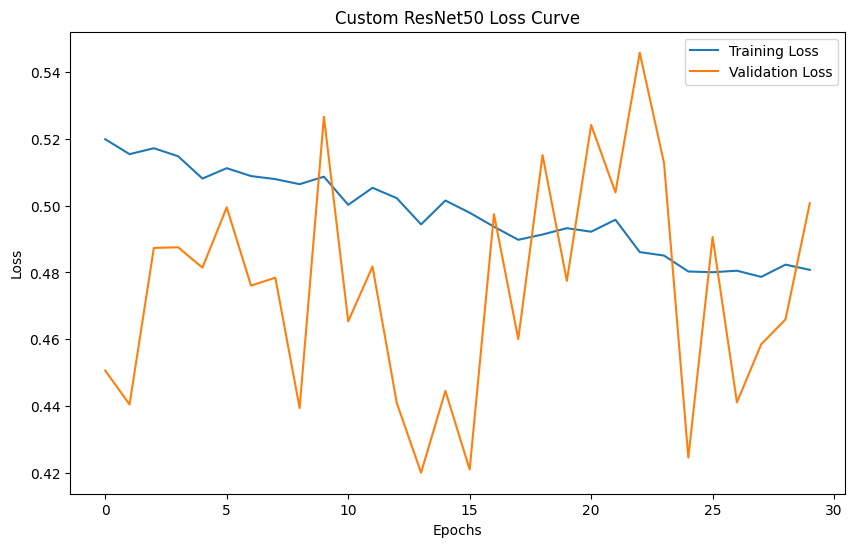

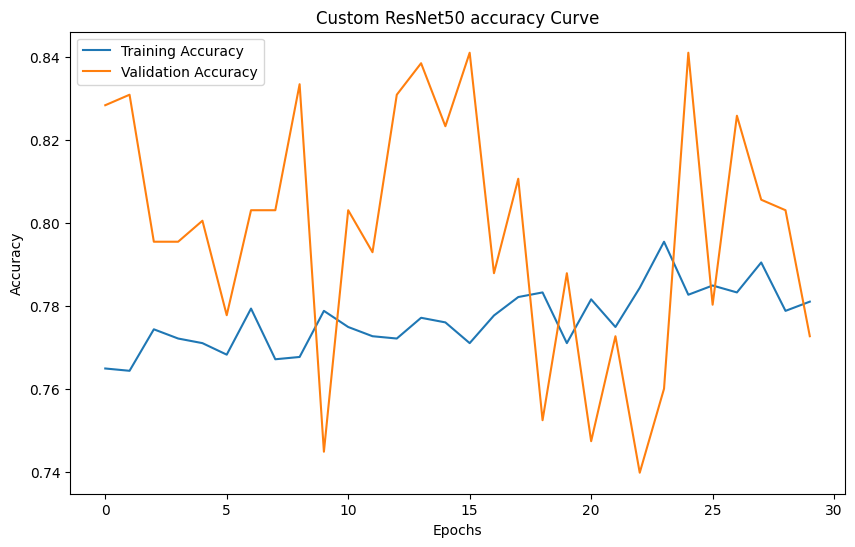

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(historyRes, title='Custom ResNet50 Loss Curve')
plot_accuracy_curve(historyRes,title='Custom ResNet50 accuracy Curve' )

In [ ]:
# Unfeeze layers

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 without the top (classification) layer
resnet_with_top = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top layers (last 10) of the model
for layer in resnet_with_top.layers[-10:]:
    layer.trainable = True

# Add a custom head for binary classification - UF and NUF
model_with_top = Sequential([
    resnet_with_top,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_with_top.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history_with_top = model_with_top.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model_with_top.evaluate(test_generator)
print(f'ResNet50 with Top Layer Test Accuracy: {accuracy:.2f}')

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7879 - loss: 0.4544 - val_accuracy: 0.5631 - val_loss: 3.0465 - learning_rate: 1.0000e-04
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 593ms/step - accuracy: 0.9601 - loss: 0.1317 - val_accuracy: 0.5631 - val_loss: 1.1063 - learning_rate: 1.0000e-04
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 520ms/step - accuracy: 0.9548 - loss: 0.1225 - val_accuracy: 0.5631 - val_loss: 0.8701 - learning_rate: 1.0000e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 527ms/step - accuracy: 0.9680 - loss: 0.0895 - val_accuracy: 0.5631 - val_loss: 3.8280 - learning_rate: 1.0000e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 503ms/step - accuracy: 0.9779 - loss: 0.0686 - val_accuracy: 0.5631 - val_loss: 1.2378 - learning_rate: 1.0000e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 542ms/step - accuracy: 0.9900 - loss: 0.0353 - val_accuracy: 0.5101 - val_loss: 0.7462 - learning_rate: 1.0000e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 612ms/step - accur

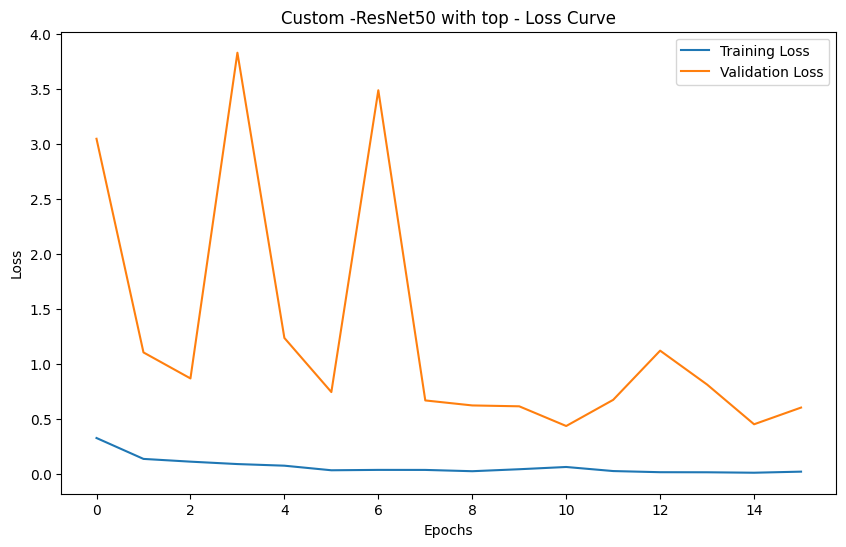

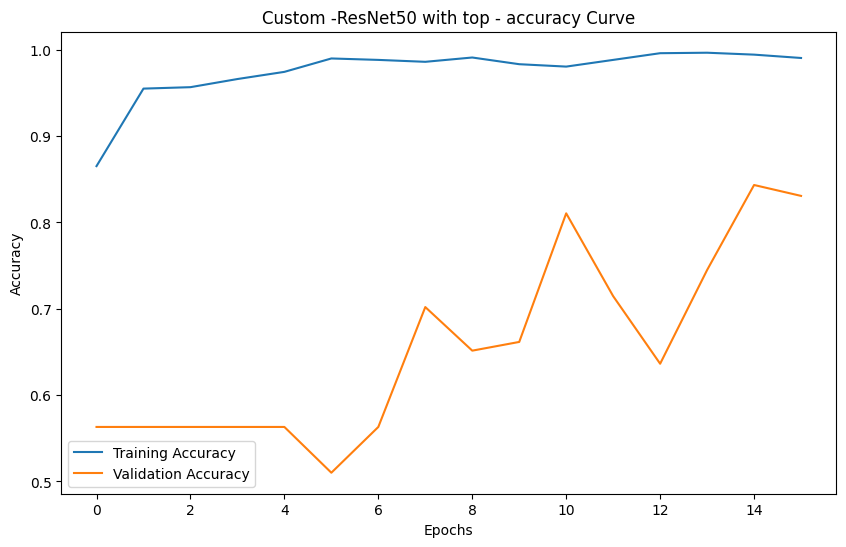

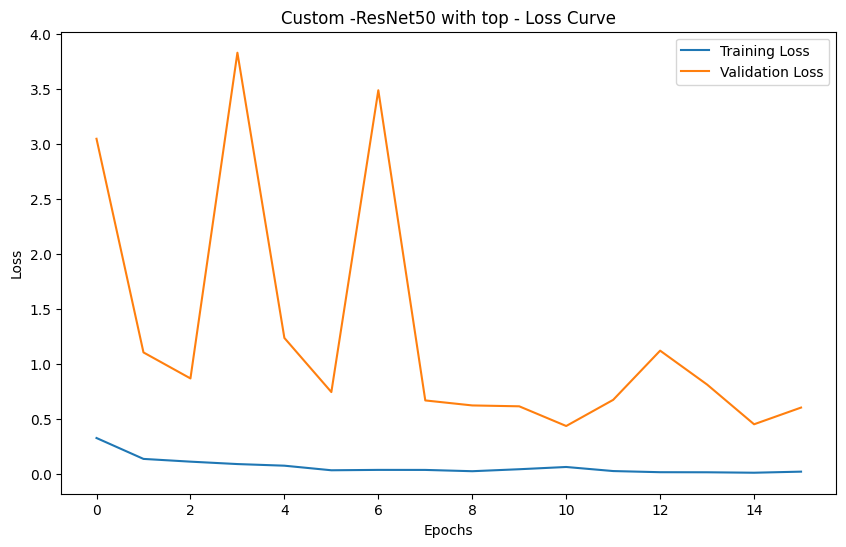

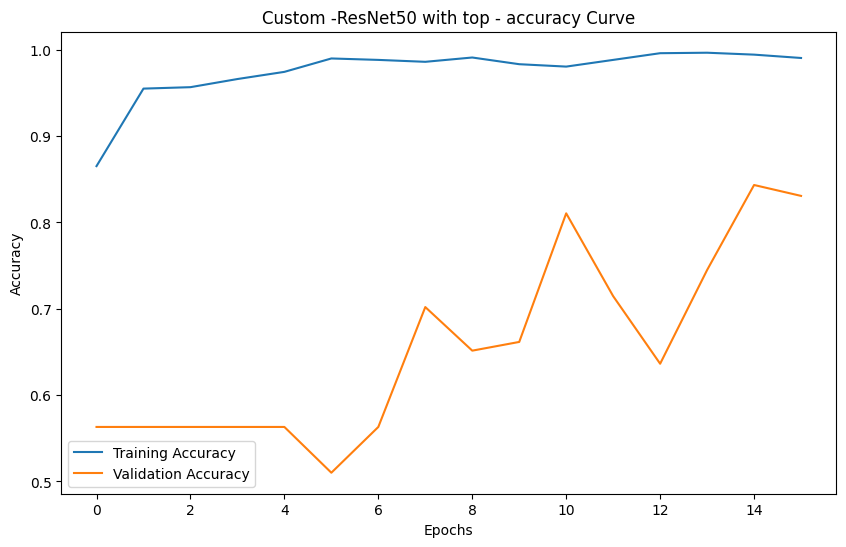

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(history_with_top, title='Custom -ResNet50 with top - Loss Curve')
plot_accuracy_curve(history_with_top,title='Custom -ResNet50 with top - accuracy Curve' )

Sensitivity (Recall): 0.53
Specificity: 0.48
Precision: 0.44
F1 Score: 0.48
Harmonic Mean of Precision and Recall: 0.48


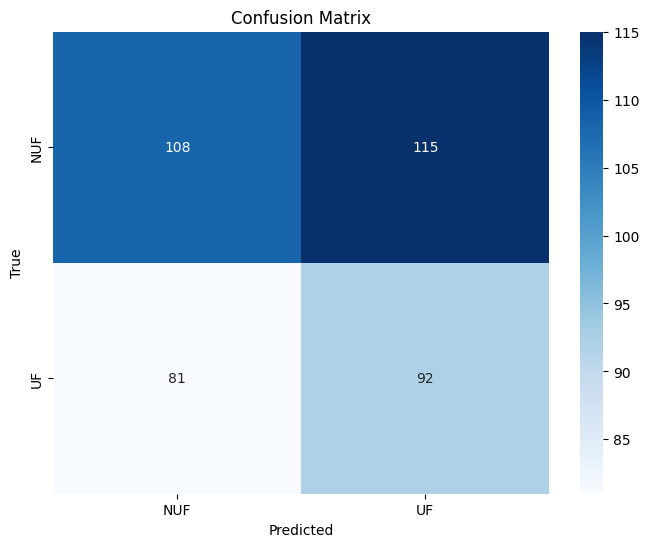

In [40]:
# Print metrics
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Harmonic Mean of Precision and Recall: {harmonic_mean:.2f}')

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=['NUF', 'UF'])

Add more layers

In [ ]:
# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
historyRes_layers = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'ResNet50layers Test Accuracy: {accuracy:.2f}')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,801,153 (94.61 MB)

 Trainable params: 1,213,441 (4.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 615ms/step - accuracy: 0.5027 - loss: 0.8494 - val_accuracy: 0.6035 - val_loss: 0.6829
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 476ms/step - accuracy: 0.5151 - loss: 0.7149 - val_accuracy: 0.4369 - val_loss: 0.6920
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 497ms/step - accuracy: 0.5497 - loss: 0.6934 - val_accuracy: 0.4369 - val_loss: 0.6746
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 495ms/step - accuracy: 0.5502 - loss: 0.6836 - val_accuracy: 0.6136 - val_loss: 0.6492
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 485ms/step - accuracy: 0.6312 - loss: 0.6590 - val_accuracy: 0.8081 - val_loss: 0.5423
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.6760 - loss: 0.6163 - val_accuracy: 0.7677 - val_loss: 0.5374
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - accuracy: 0.6930 - loss: 0.5924 - val_accuracy: 0.8207 - val_loss: 0.4739
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 463ms/step - accuracy: 0.7168 - loss: 0.5832 - val_accu

In [ ]:
# Initiate early stopping after increasing epochs


import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Set up EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
historyRes_layer = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model using the best saved model
model.load_weights('best_model.keras')
loss, accuracy = model.evaluate(test_generator)
print(f'ResNet50_Layer Test Accuracy: {accuracy:.2f}')

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,801,153 (94.61 MB)

 Trainable params: 1,213,441 (4.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 600ms/step - accuracy: 0.5118 - loss: 0.8091 - val_accuracy: 0.7222 - val_loss: 0.6866
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.5058 - loss: 0.7300 - val_accuracy: 0.5783 - val_loss: 0.6853
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 477ms/step - accuracy: 0.5365 - loss: 0.6915 - val_accuracy: 0.7146 - val_loss: 0.6772
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 482ms/step - accuracy: 0.5294 - loss: 0.6854 - val_accuracy: 0.7601 - val_loss: 0.6416
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.6160 - loss: 0.6620 - val_accuracy: 0.8157 - val_loss: 0.5660
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - accuracy: 0.6324 - loss: 0.6370 - val_accuracy: 0.8359 - val_loss: 0.5215
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.6673 - loss: 0.6150 - val_accuracy: 0.8232 - val_loss: 0.4902
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 476ms/step - accuracy: 0.6943 - loss: 0.6153 - val_accu

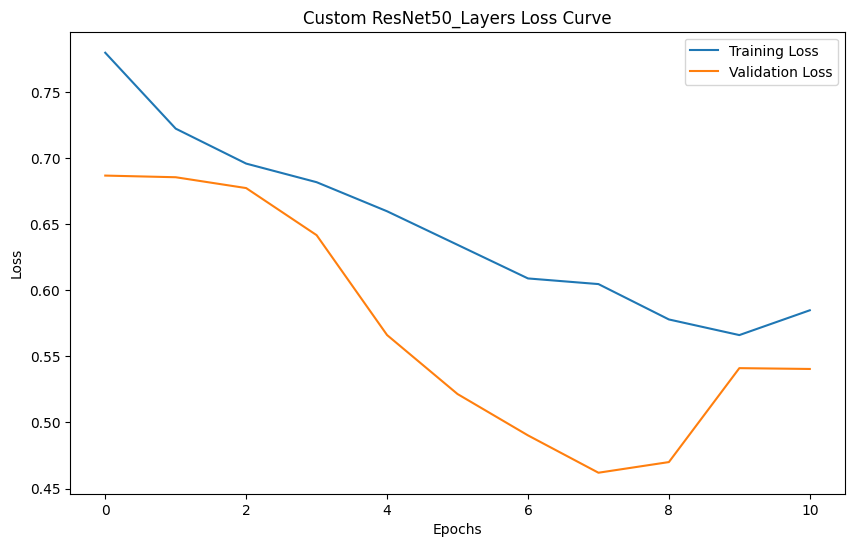

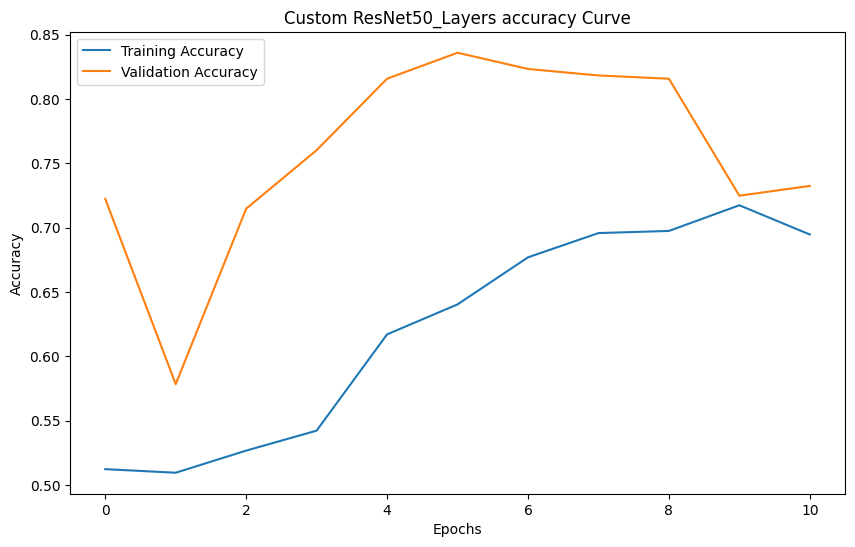

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(historyRes_layer, title='Custom ResNet50_Layers Loss Curve')
plot_accuracy_curve(historyRes_layer, title='Custom ResNet50_Layers accuracy Curve' )

Sensitivity (Recall): 0.53
Specificity: 0.48
Precision: 0.44
F1 Score: 0.48
Harmonic Mean of Precision and Recall: 0.48


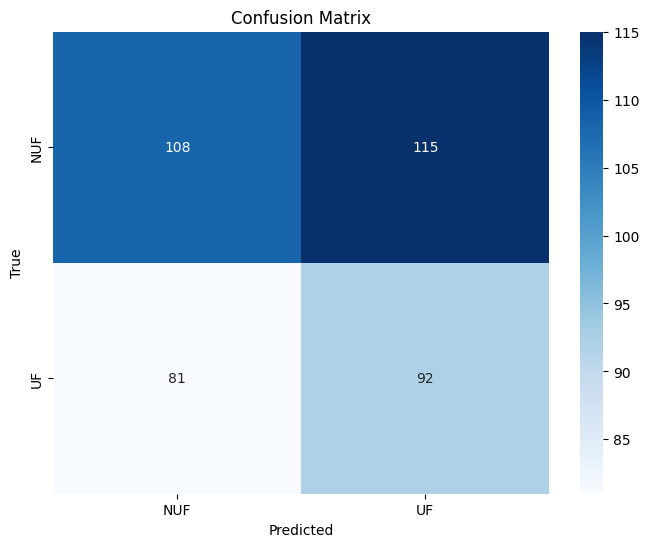

In [41]:
# Print metrics
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Harmonic Mean of Precision and Recall: {harmonic_mean:.2f}')

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=['NUF', 'UF'])

In [33]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Balance class and train with the model with the highest accuracy so far
class_names = ['NUF', 'UF']
class_indices = train_generator.class_indices

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=list(class_indices.values()),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

# Set up EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with class weights and callbacks
historyRes_layer = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 492ms/step - accuracy: 0.6848 - loss: 0.5796 - val_accuracy: 0.8106 - val_loss: 0.4855
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - accuracy: 0.6924 - loss: 0.5742 - val_accuracy: 0.7298 - val_loss: 0.5447
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.6863 - loss: 0.5771 - val_accuracy: 0.7374 - val_loss: 0.5282
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.6723 - loss: 0.5932 - val_accuracy: 0.7904 - val_loss: 0.4850
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 461ms/step - accuracy: 0.6822 - loss: 0.5827 - val_accuracy: 0.7071 - val_loss: 0.5321
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 468ms/step - accuracy: 0.6701 - loss: 0.5768 - val_accuracy: 0.5985 - val_loss: 0.6243
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 489ms/step - accuracy: 0.6390 - loss: 0.5948 - val_accuracy: 0.8283 - val_loss: 0.4719
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - accuracy: 0.5771 - loss: 0.6511 - val_accu

Sensitivity (Recall): 0.53
Specificity: 0.48
Precision: 0.44
F1 Score: 0.48
Harmonic Mean of Precision and Recall: 0.48


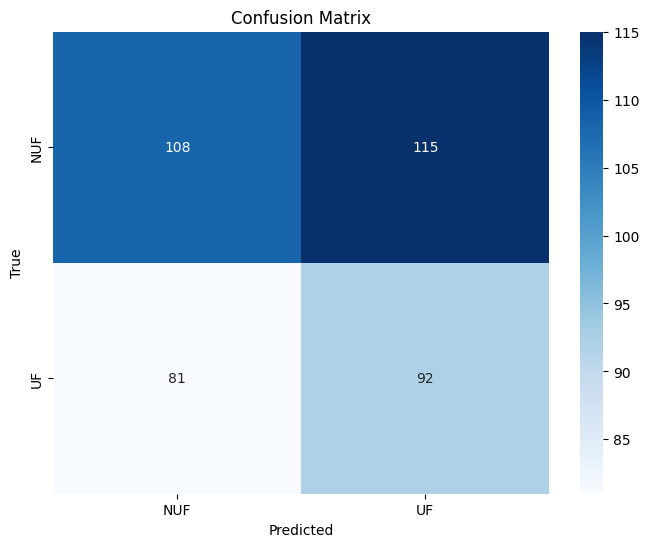

In [50]:
# Print metrics
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Harmonic Mean of Precision and Recall: {harmonic_mean:.2f}')

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=['NUF', 'UF'])

Image classification with Mobile Net

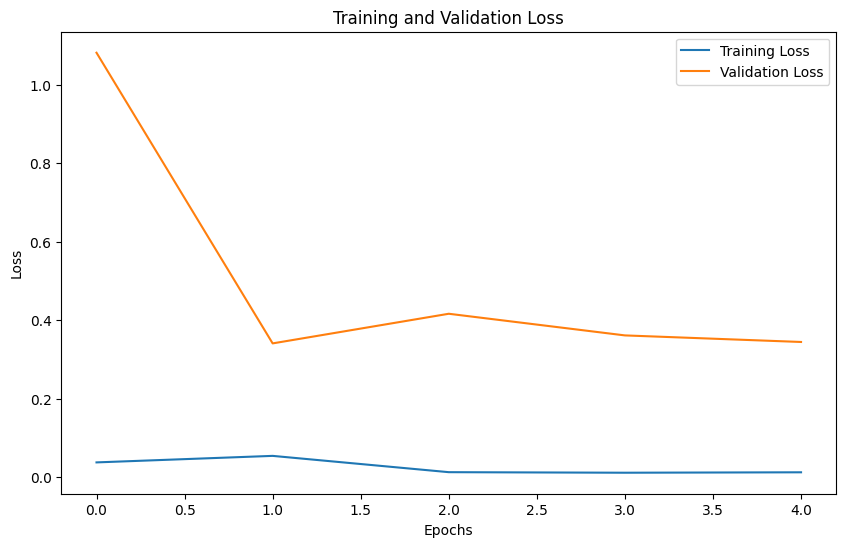

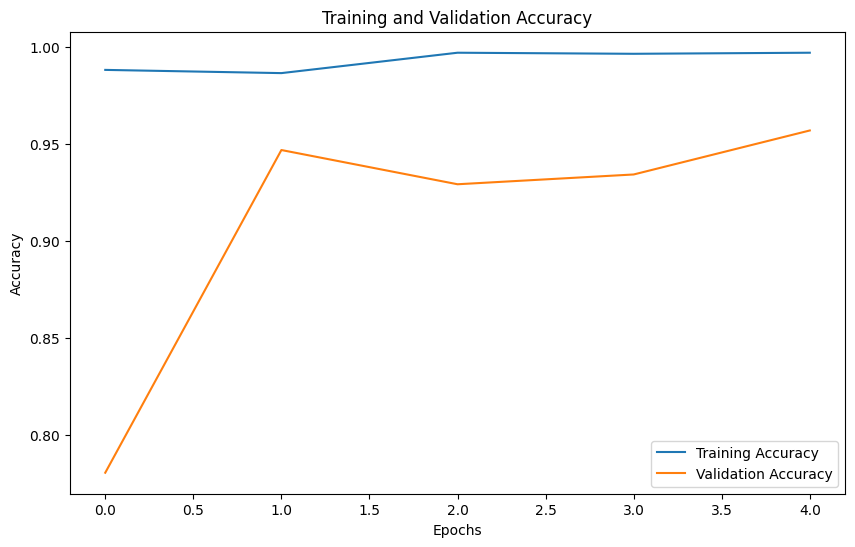

In [ ]:
# Function to plot loss curve
def plot_loss_curve(historyRes_with_Top_Many_Layers):
    plt.figure(figsize=(10, 6))
    plt.plot(historyRes_with_Top_Many_Layers.history['loss'], label='Training Loss')
    plt.plot(historyRes_with_Top_Many_Layers.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot accuracy curve
def plot_accuracy_curve(historyRes_with_Top_Many_Layers):
    plt.figure(figsize=(10, 6))
    plt.plot(historyRes_with_Top_Many_Layers.history['accuracy'], label='Training Accuracy')
    plt.plot(historyRes_with_Top_Many_Layers.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot loss and accuracy curves
plot_loss_curve(historyRes_with_Top_Many_Layers)
plot_accuracy_curve(historyRes_with_Top_Many_Layers)

In [ ]:
# Increase patience value while retaining early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
historyRes_with_Top_Many_Layers_P = model_with_top.fit(
    train_generator,
    epochs=10,  # You can increase the number of epochs for better results
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
loss, accuracy = model_with_top.evaluate(test_generator)
print(f'ResNet50 with Custom Top Layer with patience increased Test Accuracy: {accuracy:.2f}')

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 434s 8s/step - accuracy: 0.9901 - loss: 0.0299 - val_accuracy: 0.9394 - val_loss: 0.3066
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 440s 8s/step - accuracy: 0.9941 - loss: 0.0232 - val_accuracy: 0.9520 - val_loss: 0.3499
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 425s 7s/step - accuracy: 0.9877 - loss: 0.0473 - val_accuracy: 0.7222 - val_loss: 34.6496
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 424s 7s/step - accuracy: 0.9771 - loss: 0.2404 - val_accuracy: 0.9444 - val_loss: 0.4346
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9225 - loss: 0.3304
ResNet50 with Custom Top Layer with patience increased Test Accuracy: 0.94


In [55]:
# Revert to original number of layers, increase number of nodes
# Load pre-trained ResNet50 model (without top layers)

 base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Increase the number of nodes to 512
x = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
historyResNode = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')

IndentationError: unexpected indent (<ipython-input-55-6996266f91c4>, line 4)

In [57]:
# Revert to original number of layers, increase number of nodes
# Load pre-trained ResNet50 model (without top layers)
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Increase the number of nodes to 512
x = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
historyResNode = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 559ms/step - accuracy: 0.5389 - loss: 0.7580 - val_accuracy: 0.7854 - val_loss: 0.5272
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 472ms/step - accuracy: 0.7051 - loss: 0.5867 - val_accuracy: 0.8283 - val_loss: 0.4516
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - accuracy: 0.7430 - loss: 0.5401 - val_accuracy: 0.8434 - val_loss: 0.4138
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 464ms/step - accuracy: 0.6860 - loss: 0.5855 - val_accuracy: 0.8510 - val_loss: 0.3787
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 468ms/step - accuracy: 0.7250 - loss: 0.5533 - val_accuracy: 0.8056 - val_loss: 0.4589
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 507ms/step - accuracy: 0.7918 - loss: 0.4789 - val_accuracy: 0.8460 - val_loss: 0.4019
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - accuracy: 0.7231 - loss: 0.5598 - val_accuracy: 0.6288 - val_loss: 0.6576
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 464ms/step - accuracy: 0.7580 - loss: 0.5053 - val_accu

In [ ]:
# Function to plot loss curve
def plot_loss_curve(historyResNode):
    plt.figure(figsize=(10, 6))
    plt.plot(historyResNode.history['loss'], label='Training Loss')
    plt.plot(historyResNode.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot accuracy curve
def plot_accuracy_curve(historyResNode):
    plt.figure(figsize=(10, 6))
    plt.plot(historyResNode.history['accuracy'], label='Training Accuracy')
    plt.plot(historyResNode.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot loss and accuracy curves
plot_loss_curve(historyResNode)
plot_accuracy_curve(historyResNode)

In [ ]:
# Predict the classes for the test data
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Get the true classes from the generator
true_classes = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(768, activation='relu')(x)  # Increased number of nodes by 50%
x = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
historyRes = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')

# Predict the classes for the test data
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Get the true classes from the generator
true_classes = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Function to plot loss curve
def plot_loss_curve(historyResNode50):
    plt.figure(figsize=(10, 6))
    plt.plot(historyResNode50.history['loss'], label='Training Loss')
    plt.plot(historyResNode50.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot accuracy curve
def plot_accuracy_curve(historyResNode50):
    plt.figure(figsize=(10, 6))
    plt.plot(historyResNode50.history['accuracy'], label='Training Accuracy')
    plt.plot(historyResNode50.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot loss and accuracy curves
plot_loss_curve(historyResNode50)
plot_accuracy_curve(historyResNode50)

In [ ]:
# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(341, activation='relu')(x)  # Decreased number of nodes by one-third
x = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
historyResNode2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'ResNetNode2 Test Accuracy: {accuracy:.2f}')

# Predict the classes for the test data
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Get the true classes from the generator
true_classes = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Function to plot loss curve
def plot_loss_curve(historyResNode2):
    plt.figure(figsize=(10, 6))
    plt.plot(historyResNode2.history['loss'], label='Training Loss')
    plt.plot(historyResNode2.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot accuracy curve
def plot_accuracy_curve(historyResNode2):
    plt.figure(figsize=(10, 6))
    plt.plot(historyResNode2.history['accuracy'], label='Training Accuracy')
    plt.plot(historyResNode2.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot loss and accuracy curves
plot_loss_curve(historyResNode2)
plot_accuracy_curve(historyResNode2)

In [ ]:
# Initiate MobileNet
# Make all necessary imports
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load MobileNetV3 Large model without the top layer
mobilenet_v3_base = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in mobilenet_v3_base.layers:
    layer.trainable = False

# Add custom layers on top
model_with_top = Sequential([
    mobilenet_v3_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

Found 1804 images belonging to 2 classes.
Found 396 images belonging to 2 classes.
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model_with_top.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [ ]:
# Train the model
historyMob = model_with_top.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test data
loss, accuracy = model_with_top.evaluate(test_generator)
print(f'MobileNetV3 Large with Custom Enhancements Test Accuracy: {accuracy:.2f}')

# Save the model
model_with_top.save('/content/drive/MyDrive/UF_dataset/mobilenetv3_large_custom.h5')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 861ms/step - accuracy: 0.5161 - loss: 0.7087 - val_accuracy: 0.6869 - val_loss: 0.6443 - learning_rate: 1.0000e-04
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 824ms/step - accuracy: 0.5559 - loss: 0.7004 - val_accuracy: 0.8788 - val_loss: 0.6256 - learning_rate: 1.0000e-04
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 830ms/step - accuracy: 0.5495 - loss: 0.6898 - val_accuracy: 0.7904 - val_loss: 0.6169 - learning_rate: 1.0000e-04
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 812ms/step - accuracy: 0.5973 - loss: 0.6662 - val_accuracy: 0.7652 - val_loss: 0.6036 - learning_rate: 1.0000e-04
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 829ms/step - accuracy: 0.6198 - loss: 0.6537 - val_accuracy: 0.7753 - val_loss: 0.5888 - learning_rate: 1.0000e-04
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 832ms/step - accuracy: 0.6317 - loss: 0.6459 - val_accuracy: 0.7652 - val_loss: 0.5786 - learning_rate: 1.0000e-04
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 818ms/step - accuracy: 0.61

MobileNetV3 Large with Custom Enhancements Test Accuracy: 0.87


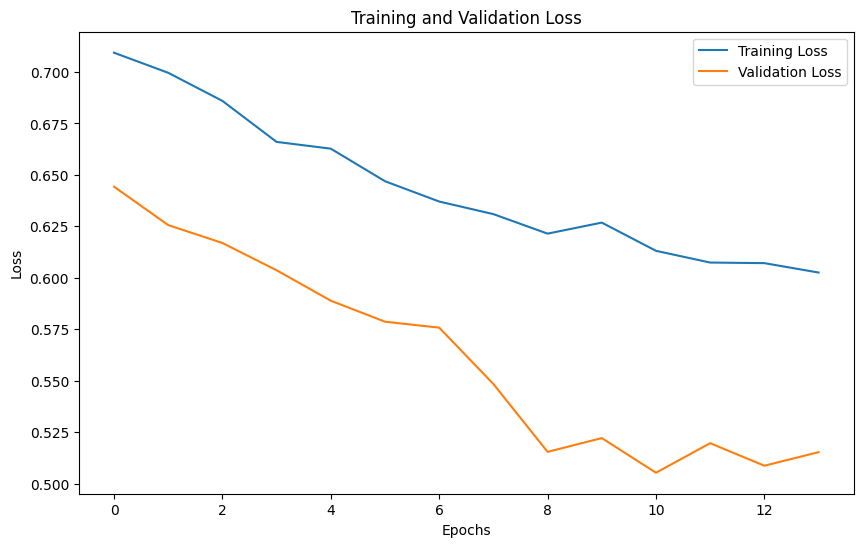

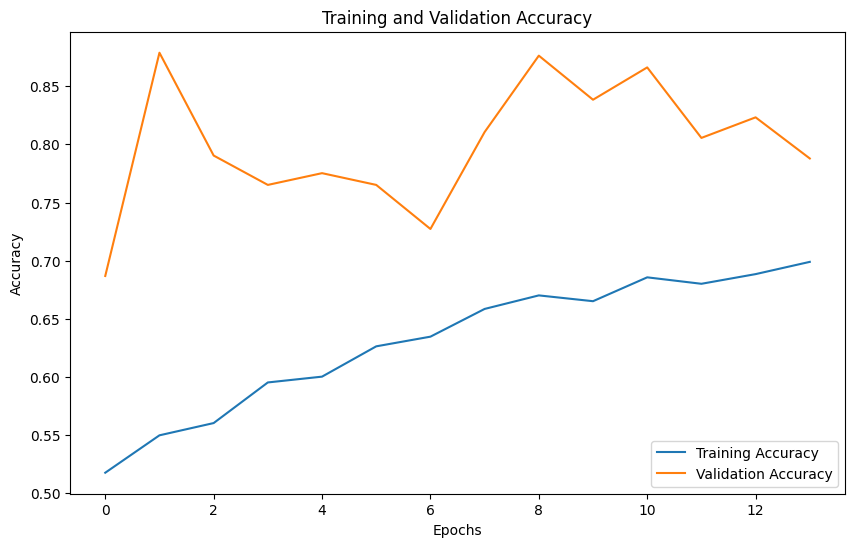

In [ ]:
# Function to plot loss curve
def plot_loss_curve(historyMob):
    plt.figure(figsize=(10, 6))
    plt.plot(historyMob.history['loss'], label='Training Loss')
    plt.plot(historyMob.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot accuracy curve
def plot_accuracy_curve(historyMob):
    plt.figure(figsize=(10, 6))
    plt.plot(historyMob.history['accuracy'], label='Training Accuracy')
    plt.plot(historyMob.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot loss and accuracy curves
plot_loss_curve(historyMob)
plot_accuracy_curve(historyMob)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Set t-SNE Feature Visualization:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/st

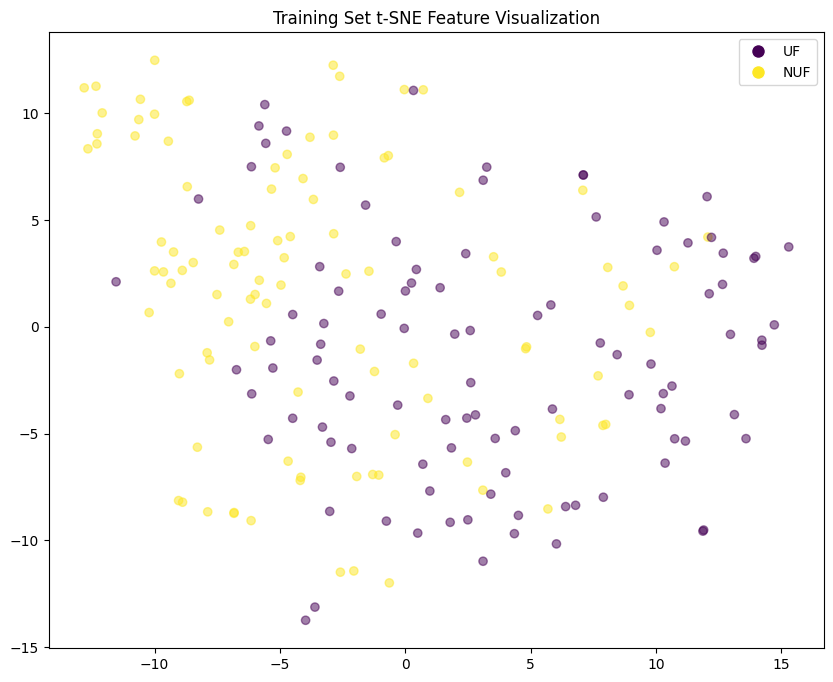

Testing Set t-SNE Feature Visualization:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━

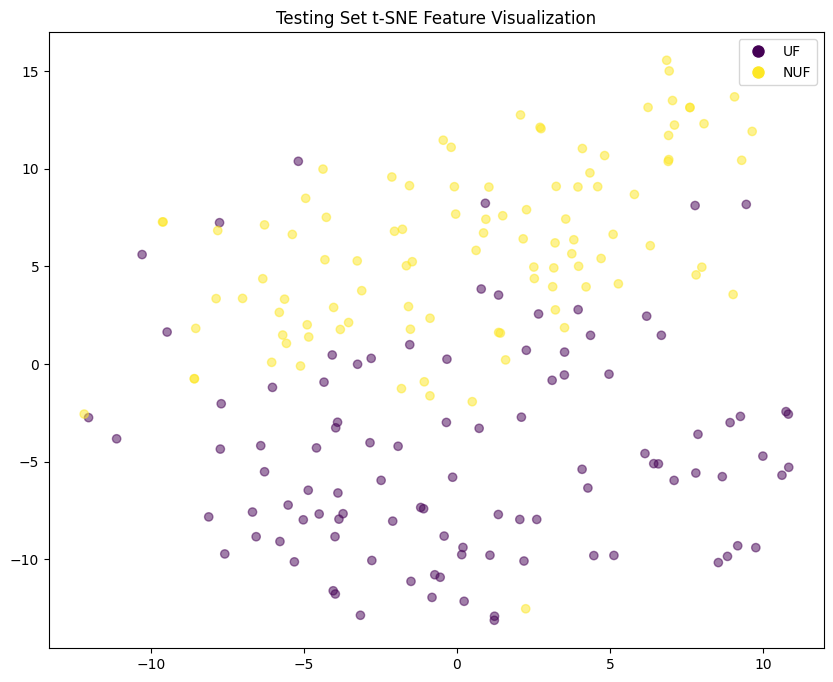

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the pre-trained MobileNetV3 model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to extract features using MobileNetV3
def extract_features(directory, model, num_images_per_class=100):
    features = []
    labels = []
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        files = os.listdir(class_path)[:num_images_per_class]

        for file in files:
            if file.endswith(('jpg', 'png', 'jpeg')):
                image_path = os.path.join(class_path, file)
                with Image.open(image_path) as img:
                    img_resized = img.resize((224, 224))
                    img_array = img_to_array(img_resized) / 255.0
                    img_array = np.expand_dims(img_array, axis=0)

                    feature = model.predict(img_array)
                    features.append(feature.flatten())
                    labels.append(class_dir)

    return np.array(features), labels

# Function to plot t-SNE features with class labels
def plot_tsne_features(features, labels, title):
    plt.figure(figsize=(10, 8))
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)

    # Convert labels to numeric values for coloring
    unique_labels = list(set(labels))
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
    colors = [label_to_color[label] for label in labels]

    scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], alpha=0.5, c=colors, cmap='viridis')
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10) for value in range(len(unique_labels))]
    plt.legend(handles, unique_labels)

    plt.title(title)
    plt.show()

# Define directories
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# Extract and plot features for the training set
print("Training Set t-SNE Feature Visualization:")
train_features, train_labels = extract_features(train_directory, model)
plot_tsne_features(train_features, train_labels, 'Training Set t-SNE Feature Visualization')

# Extract and plot features for the testing set
print("Testing Set t-SNE Feature Visualization:")
test_features, test_labels = extract_features(test_directory, model)
plot_tsne_features(test_features, test_labels, 'Testing Set t-SNE Feature Visualization')


In [53]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Concatenate, BatchNormalization, Activation, Reshape, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [54]:
# Data Augmentation
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_data_generators(train_dir, test_dir, target_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_generator, test_generator


In [ ]:
#Compute the class weights
def compute_class_weights(train_dir):
    class_counts = {}
    total_count = 0
    for subdir in os.listdir(train_dir):
        class_path = os.path.join(train_dir, subdir)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[subdir] = count
            total_count += count

    class_weights = {i: total_count/count for i, (subdir, count) in enumerate(class_counts.items())}
    return class_weights


In [ ]:
import shutil

def oversample_minority_class(train_dir):
    class_counts = {subdir: len(os.listdir(os.path.join(train_dir, subdir))) for subdir in os.listdir(train_dir)}
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)

    majority_count = class_counts[majority_class]
    minority_count = class_counts[minority_class]

    minority_class_dir = os.path.join(train_dir, minority_class)

    for i in range(majority_count - minority_count):
        filename = np.random.choice(os.listdir(minority_class_dir))
        shutil.copy(os.path.join(minority_class_dir, filename), os.path.join(minority_class_dir, f'copy_{i}_{filename}'))


In [ ]:
# Oversample minority class
oversample_minority_class(train_directory)

# Get data generators
train_generator, test_generator = get_data_generators(train_directory, test_directory)

# Compute class weights
class_weights = compute_class_weights(train_directory)

Found 1804 images belonging to 2 classes.
Found 396 images belonging to 2 classes.


In [ ]:
# Define and train your model, increase the epochs and include early dropout
def create_model(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

history_Res50_with_Augmentation = model.fit(
    train_generator,
epochs=20,
    validation_data=test_generator,
    class_weight=class_weights,
)
print(f'ResNet50 following data augmentation Test Accuracy: {accuracy:.2f}')

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5084 - loss: 1.3948 - val_accuracy: 0.7071 - val_loss: 0.6475
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5968 - loss: 1.3447 - val_accuracy: 0.8232 - val_loss: 0.6151
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6080 - loss: 1.3280 - val_accuracy: 0.7879 - val_loss: 0.5859
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6563 - loss: 1.3013 - val_accuracy: 0.6616 - val_loss: 0.6100
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6504 - loss: 1.2977 - val_accuracy: 0.8333 - val_loss: 0.5560
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6399 - loss: 1.2932 - val_accuracy: 0.8359 - val_loss: 0.5505
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6476 - loss: 1.2853 - val_accuracy: 0.7980 - val_loss: 0.5275
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6458 - loss: 1.2869 - val_accuracy: 0.7980 - v

In [ ]:
# Function to plot loss curve
def plot_loss_curve(history_Res50_with_Augmentation):
    plt.figure(figsize=(10, 6))
    plt.plot(history_Res50_with_Augmentation.history['loss'], label='Training Loss')
    plt.plot(history_Res50_with_Augmentation.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot accuracy curve
def plot_accuracy_curve(history_Res50_with_Augmentation):
    plt.figure(figsize=(10, 6))
    plt.plot(.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot loss and accuracy curves
plot_loss_curve(history_Res50_with_Augmentation)
plot_accuracy_curve(history_Res50_with_Augmentation)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')

In [ ]:
# Define and train your MobileNet model
def create_mobilenet_model(input_shape=(224, 224, 3)):
    mobilenet_v3_base = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in mobilenet_v3_base.layers:
        layer.trainable = False

    x = mobilenet_v3_base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=mobilenet_v3_base.input, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_mobilenet_model()

historyMobileNet = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    class_weight=class_weights
)

In [ ]:
# Function to plot loss curve
def plot_loss_curve(historyMobileNet):
    plt.figure(figsize=(10, 6))
    plt.plot(historyMobileNet.history['loss'], label='Training Loss')
    plt.plot(historyMobileNet.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot accuracy curve
def plot_accuracy_curve(historyMobileNet):
    plt.figure(figsize=(10, 6))
    plt.plot(historyMobileNet.history['accuracy'], label='Training Accuracy')
    plt.plot(historyMobileNet.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot loss and accuracy curves
plot_loss_curve(historyMobileNet)
plot_accuracy_curve(historyMobileNet)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'MobileNetV3 following data augmentation Test Accuracy: {accuracy:.2f}')